# NLP analysis for NIS800-53

This is the next notebook to 'NIS800-53 analysis'

In this notebook, we will continue trying to figure out the relationships between the NIS800-53 regulations in a human-independent way. 
This is after in the previous notebook we saw that the given NIS800-53 relationships between the regulations failed to do what they were supposed to do.

We will try to use Natural Language Processing (NLP) to help us better understand the relationships between the regulations. 
In this notebook we will use the following:
* BM25 embedding as the classical NLP method
* A Sentence Transformers model taken from HuggingFace🤗 as the free open-source NLP solution
* A SaaS NLP embedding service as the NLP commercial service option




In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import networkx as nx

import bm25s
import Stemmer 

from sentence_transformers import SentenceTransformer

import google.generativeai as genai

import os




resource module not available on Windows


# Read the NIS800-53 regulations

The first few steps of reading and cleaning the NIS800-53 regulations are the same as in the first notebook.

In [2]:

NIS_regulations = pd.read_excel("regulations//sp800-53r5-control-catalog.xlsx")
NIS_regulations


,Control Identifier,Control (or Control Enhancement) Name,Control Text,Discussion,Related Controls
0,AC-1,Policy and Procedures,"a. Develop, document, and disseminate to [Assi...",Access control policy and procedures address t...,"IA-1, PM-9, PM-24, PS-8, SI-12 ."
1,AC-2,Account Management,a. Define and document the types of accounts a...,Examples of system account types include indiv...,"AC-3, AC-5, AC-6, AC-17, AC-18, AC-20, AC-24, ..."
2,AC-2(1),Account Management | Automated System Account ...,Support the management of system accounts usin...,Automated system account management includes u...,None.
3,AC-2(2),Account Management | Automated Temporary and E...,Automatically [Selection: remove; disable] tem...,Management of temporary and emergency accounts...,None.
4,AC-2(3),Account Management | Disable Accounts,Disable accounts within [Assignment: organizat...,"Disabling expired, inactive, or otherwise anom...",None.
...,...,...,...,...,...
1184,SR-11,Component Authenticity,a. Develop and implement anti-counterfeit poli...,Sources of counterfeit components include manu...,"PE-3, SA-4, SI-7, SR-9, SR-10."
1185,SR-11(1),Component Authenticity | Anti-counterfeit Trai...,Train [Assignment: organization-defined person...,None.,AT-3.
1186,SR-11(2),Component Authenticity | Configuration Control...,Maintain configuration control over the follow...,None.,"CM-3, MA-2, MA-4, SA-10."
1187,SR-11(3),Component Authenticity | Anti-counterfeit Scan...,Scan for counterfeit system components [Assign...,The type of component determines the type of s...,RA-5.


## Add columns for "Main Control Name" and "Family Name"

In [3]:

NIS_regulations["Main Control Name"] = NIS_regulations["Control Identifier"].apply(lambda x: x[:x.find("(")] if x.find("(") != -1 else x)
NIS_regulations["Family Name"] = NIS_regulations["Control Identifier"].str[:2]

# NIS_regulations["Control Identifier"].str.find("(")
# NIS_regulations["Control Identifier"].str[:NIS_regulations["Control Identifier"].str.find("(")]

# NIS_regulations["Control Identifier"].apply(lambda x: x[:x.find("(")] if x.find("(") != -1 else x)


# Drop all Withdrawn Controls

In [4]:

NIS_regulations["Control Text"].str.contains("Withdrawn: ")
sum(NIS_regulations["Control Text"].str.contains("Withdrawn: "))

Active_NIS_regulations = NIS_regulations.loc[~NIS_regulations["Control Text"].str.contains("Withdrawn: ")]
Active_NIS_regulations


,Control Identifier,Control (or Control Enhancement) Name,Control Text,Discussion,Related Controls,Main Control Name,Family Name
0,AC-1,Policy and Procedures,"a. Develop, document, and disseminate to [Assi...",Access control policy and procedures address t...,"IA-1, PM-9, PM-24, PS-8, SI-12 .",AC-1,AC
1,AC-2,Account Management,a. Define and document the types of accounts a...,Examples of system account types include indiv...,"AC-3, AC-5, AC-6, AC-17, AC-18, AC-20, AC-24, ...",AC-2,AC
2,AC-2(1),Account Management | Automated System Account ...,Support the management of system accounts usin...,Automated system account management includes u...,None.,AC-2,AC
3,AC-2(2),Account Management | Automated Temporary and E...,Automatically [Selection: remove; disable] tem...,Management of temporary and emergency accounts...,None.,AC-2,AC
4,AC-2(3),Account Management | Disable Accounts,Disable accounts within [Assignment: organizat...,"Disabling expired, inactive, or otherwise anom...",None.,AC-2,AC
...,...,...,...,...,...,...,...
1184,SR-11,Component Authenticity,a. Develop and implement anti-counterfeit poli...,Sources of counterfeit components include manu...,"PE-3, SA-4, SI-7, SR-9, SR-10.",SR-11,SR
1185,SR-11(1),Component Authenticity | Anti-counterfeit Trai...,Train [Assignment: organization-defined person...,None.,AT-3.,SR-11,SR
1186,SR-11(2),Component Authenticity | Configuration Control...,Maintain configuration control over the follow...,None.,"CM-3, MA-2, MA-4, SA-10.",SR-11,SR
1187,SR-11(3),Component Authenticity | Anti-counterfeit Scan...,Scan for counterfeit system components [Assign...,The type of component determines the type of s...,RA-5.,SR-11,SR


There are 1007 controls and sub-controls after removing all Withdrawn controls and sub-controls


## Fix problem with relation to Withdrawn Control AU-15
Change to AU-5
[Withdrawn: Moved to AU-5(5).]

In [5]:

# Active_NIS_regulations["Related Controls"] = Active_NIS_regulations["Related Controls"].str.replace("AU-15","AU-5")
Active_NIS_regulations.loc[:,"Related Controls"] = Active_NIS_regulations.loc[:,"Related Controls"].str.replace("AU-15","AU-5")

# Active_NIS_regulations.loc[Active_NIS_regulations["Main Control Name"]=="AU-5"]


In [6]:
Active_NIS_regulations

,Control Identifier,Control (or Control Enhancement) Name,Control Text,Discussion,Related Controls,Main Control Name,Family Name
0,AC-1,Policy and Procedures,"a. Develop, document, and disseminate to [Assi...",Access control policy and procedures address t...,"IA-1, PM-9, PM-24, PS-8, SI-12 .",AC-1,AC
1,AC-2,Account Management,a. Define and document the types of accounts a...,Examples of system account types include indiv...,"AC-3, AC-5, AC-6, AC-17, AC-18, AC-20, AC-24, ...",AC-2,AC
2,AC-2(1),Account Management | Automated System Account ...,Support the management of system accounts usin...,Automated system account management includes u...,None.,AC-2,AC
3,AC-2(2),Account Management | Automated Temporary and E...,Automatically [Selection: remove; disable] tem...,Management of temporary and emergency accounts...,None.,AC-2,AC
4,AC-2(3),Account Management | Disable Accounts,Disable accounts within [Assignment: organizat...,"Disabling expired, inactive, or otherwise anom...",None.,AC-2,AC
...,...,...,...,...,...,...,...
1184,SR-11,Component Authenticity,a. Develop and implement anti-counterfeit poli...,Sources of counterfeit components include manu...,"PE-3, SA-4, SI-7, SR-9, SR-10.",SR-11,SR
1185,SR-11(1),Component Authenticity | Anti-counterfeit Trai...,Train [Assignment: organization-defined person...,None.,AT-3.,SR-11,SR
1186,SR-11(2),Component Authenticity | Configuration Control...,Maintain configuration control over the follow...,None.,"CM-3, MA-2, MA-4, SA-10.",SR-11,SR
1187,SR-11(3),Component Authenticity | Anti-counterfeit Scan...,Scan for counterfeit system components [Assign...,The type of component determines the type of s...,RA-5.,SR-11,SR


# transform the old Related Controls from the string NIS representation to the new Dictionary representation

In [7]:

# Related_Controls = row["Related Controls"].replace(" .","").replace(".","").split(", ")
# apply the replace and split operation on the Related Controls column to get a list of related controls
# Active_NIS_regulations["Related Controls"].apply(lambda x: {k: v for k, v in (i.split("-") for i in x.replace(" .","").replace(".","").split(", ")) if v is not None else None })
new_NIS_Related_Controls = Active_NIS_regulations["Related Controls"].astype(str).apply(lambda x: x.replace(" .","").replace(".","").split(", "))
# transform the list of related controls into a dictionary where the key is the control and the value is 0.5
# new_NIS_Related_Controls[3]
# {x: 0.5 for x in new_NIS_Related_Controls[0] if x != "None"}
new_NIS_Related_Controls = new_NIS_Related_Controls.apply(lambda x: {k: 0.5 for k in x if k!= "None"})
Active_NIS_regulations["Related Controls Dictionary"] = new_NIS_Related_Controls

new_NIS_Related_Controls


C:\Users\User\AppData\Local\Temp\ipykernel_20376\529615601.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_NIS_regulations["Related Controls Dictionary"] = new_NIS_Related_Controls


0       {'IA-1': 0.5, 'PM-9': 0.5, 'PM-24': 0.5, 'PS-8...
1       {'AC-3': 0.5, 'AC-5': 0.5, 'AC-6': 0.5, 'AC-17...
2                                                      {}
3                                                      {}
4                                                      {}
                              ...                        
1184    {'PE-3': 0.5, 'SA-4': 0.5, 'SI-7': 0.5, 'SR-9'...
1185                                        {'AT-3': 0.5}
1186    {'CM-3': 0.5, 'MA-2': 0.5, 'MA-4': 0.5, 'SA-10...
1187                                        {'RA-5': 0.5}
1188                                        {'MP-6': 0.5}
Name: Related Controls, Length: 1007, dtype: object

# Make full text column

<"Control (or Control Enhancement) Name">



<"Control Text">

We are constructing a column combining the Header and the Text in order to give it to our embedding models later.

In [8]:

Active_NIS_regulations.loc[:,"Full Text"] = Active_NIS_regulations["Control (or Control Enhancement) Name"].copy() + "\n\n" + Active_NIS_regulations["Control Text"].copy()
print(Active_NIS_regulations.loc[0,"Full Text"])

Policy and Procedures

a. Develop, document, and disseminate to [Assignment: organization-defined personnel or roles]:
1. [Selection (one or more): Organization-level; Mission/business process-level; System-level] access control policy that:
(a) Addresses purpose, scope, roles, responsibilities, management commitment, coordination among organizational entities, and compliance; and
(b) Is consistent with applicable laws, executive orders, directives, regulations, policies, standards, and guidelines; and
2. Procedures to facilitate the implementation of the access control policy and the associated access controls;
b. Designate an [Assignment: organization-defined official] to manage the development, documentation, and dissemination of the access control policy and procedures; and
c. Review and update the current access control:
1. Policy [Assignment: organization-defined frequency] and following [Assignment: organization-defined events]; and
2. Procedures [Assignment: organization-define

C:\Users\User\AppData\Local\Temp\ipykernel_20376\2779223040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_NIS_regulations.loc[:,"Full Text"] = Active_NIS_regulations["Control (or Control Enhancement) Name"].copy() + "\n\n" + Active_NIS_regulations["Control Text"].copy()


Now we start the main part of making text embeddings of the regulations with the methods we described at the start.



# Make BM25 embeddings

We are using the BM25 encoding as it is the most common classical NLP embedding method.
It is still used even in our AI-boom, mainly as a pre/post-filter for embedding and retrieving tasks.



In [9]:
Active_NIS_regulations.loc[:,"Full Text"].reset_index(drop=True)

0       Policy and Procedures\n\na. Develop, document,...
1       Account Management\n\na. Define and document t...
2       Account Management | Automated System Account ...
3       Account Management | Automated Temporary and E...
4       Account Management | Disable Accounts\n\nDisab...
                              ...                        
1002    Component Authenticity\n\na. Develop and imple...
1003    Component Authenticity | Anti-counterfeit Trai...
1004    Component Authenticity | Configuration Control...
1005    Component Authenticity | Anti-counterfeit Scan...
1006    Component Disposal\n\nDispose of [Assignment: ...
Name: Full Text, Length: 1007, dtype: object

## Use bm25s to make the bm25 embeddings

Template steps from the bm25s documentation.

In [10]:
# Create your corpus here
# corpus = Active_NIS_regulations.loc[:,"Full Text"].to_list()
corpus = Active_NIS_regulations.loc[:,"Full Text"].reset_index(drop=True)

# optional: create a stemmer
stemmer = Stemmer.Stemmer("english")

# Tokenize the corpus and only keep the ids (faster and saves memory)
corpus_tokens = bm25s.tokenize(corpus, stopwords="en", stemmer=stemmer)

# Create the BM25 model and index the corpus
retriever = bm25s.BM25()
retriever.index(corpus_tokens)


Split strings:   0%|          | 0/1007 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1007 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/1007 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/1007 [00:00<?, ?it/s]

## Make the full bm25 score matrix of all the controls against themselves

We want to see the full statistics of all the bm25 scores for all the regulations pairs comparisons.

In [11]:
print(Active_NIS_regulations.sample()["Full Text"].iloc[0])

Spam Protection

a. Employ spam protection mechanisms at system entry and exit points to detect and act on unsolicited messages; and
b. Update spam protection mechanisms when new releases are available in accordance with organizational configuration management policy and procedures.


In [12]:


# Query the corpus
# query = "Identifying potential accessibility problems to the alternate storage sites"
# query = "Establish agreements and procedures with entities involved in the supply chain for the system"
# query = ["Identifying potential accessibility problems to the alternate storage sites", 
#          "Establish agreements and procedures with entities involved in the supply chain for the system"]
query = corpus
query_tokens = bm25s.tokenize(query, stemmer=stemmer)

# Get top-k results as a tuple of (doc ids, scores). Both are arrays of shape (n_queries, k)
# results, scores = retriever.retrieve(query_tokens, corpus=corpus, k=len(query), sorted=False)
results, scores = retriever.retrieve(query_tokens, k=len(query), sorted=True)

for i in range(int(results.shape[1]**0.5)):
    doc, score = results[0, i], scores[0, i]
    print(f"Rank {i+1} (score: {score:.2f}): {doc}")




Split strings:   0%|          | 0/1007 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1007 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1007 [00:00<?, ?it/s]

Rank 1 (score: 66.26): 0
Rank 2 (score: 59.28): 427
Rank 3 (score: 59.28): 526
Rank 4 (score: 58.71): 227
Rank 5 (score: 58.40): 387
Rank 6 (score: 58.33): 574
Rank 7 (score: 57.47): 455
Rank 8 (score: 57.47): 131
Rank 9 (score: 57.47): 283
Rank 10 (score: 57.47): 146
Rank 11 (score: 57.47): 612
Rank 12 (score: 57.47): 332
Rank 13 (score: 56.02): 879
Rank 14 (score: 56.02): 740
Rank 15 (score: 56.02): 634
Rank 16 (score: 55.78): 475
Rank 17 (score: 55.78): 202
Rank 18 (score: 55.42): 980
Rank 19 (score: 53.35): 591
Rank 20 (score: 34.94): 556
Rank 21 (score: 26.50): 27
Rank 22 (score: 25.70): 19
Rank 23 (score: 23.11): 25
Rank 24 (score: 23.00): 127
Rank 25 (score: 22.90): 17
Rank 26 (score: 22.69): 195
Rank 27 (score: 22.50): 16
Rank 28 (score: 22.05): 537
Rank 29 (score: 21.62): 565
Rank 30 (score: 21.28): 557
Rank 31 (score: 21.08): 567


In [13]:
query[0]
corpus[0]
query[0] == corpus[0]
results[0,:]
# results[:,0]

# corpus[1] == results[1,0]

results[0,:] == 0
scores[0, results[0,:] == 0]



array([66.255295], dtype=float32)

In [14]:
scores.shape
# scores[:10,:10]
# results.shape
# results

(1007, 1007)

How the BM25 scores statistics look?

max bm25 Score = 143.0639190673828
min bm25 Score = 0.0
mean bm25 Score = 2.414163589477539
std bm25 Score = 3.6262242794036865


count    1.014049e+06
mean     2.414164e+00
std      3.627960e+00
min      0.000000e+00
10%      0.000000e+00
25%      4.576505e-01
50%      1.405209e+00
75%      3.088399e+00
90%      5.733497e+00
95%      8.123824e+00
99%      1.557623e+01
max      1.430639e+02
dtype: float64

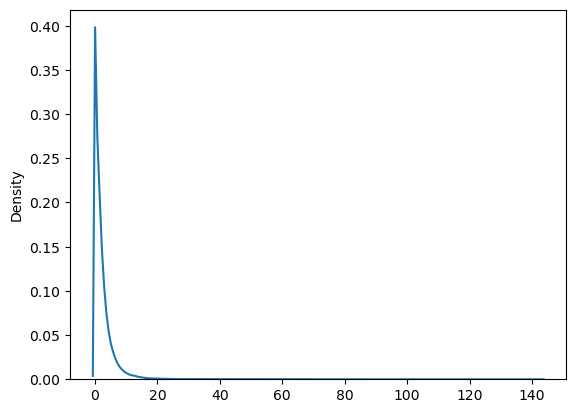

In [15]:

scores.flatten().shape
bm25_scores = pd.Series(scores.flatten())
# sns.histplot(scores.flatten())
sns.kdeplot(scores.flatten())
print(f"max bm25 Score = {scores.flatten().max()}")
print(f"min bm25 Score = {scores.flatten().min()}")
print(f"mean bm25 Score = {scores.flatten().mean()}")
print(f"std bm25 Score = {scores.flatten().std()}")
bm25_scores.describe(percentiles=[.1,.25,.5,.75,.9,.95,.99])



## Extract related controls from the BM25 scores

We will determine a score threshold and take every regulation pair with a score above that threshold as related.

Similar to the original "Related Controls" listing, we will make the relations relate to the main control, even if the similar regulation is a sub-control(the relation will go to its main control).

As additional data, we are saving the relations scores, so we may use them to calculate the weights for the network analysis.


In [16]:

# what is the minimal score for a control to be considered related
# # a hardcoded threshold
# minimal_related_bm25_score: float = 0.5
# # a threshold as a quantile of the scores distribution
# minimal_related_bm25_score: float = bm25_scores.quantile(.99)
# a threshold as the number of expected relations
n = 4 # number of expected relations
minimal_related_bm25_score: float = bm25_scores.quantile(1-n/scores.shape[1])

# set a minimal number of relations wanted per regulation (that are different from the main)
min_relations_per_regulation: int = 1


# add a column for the bm25 Related Controls
Active_NIS_regulations.loc[:,"bm25 Related Controls"] = None

# go over every regulation
for i in range(scores.shape[0]):
    # go over all the other regulations to check if they are related
    # related_regulations:list = []
    regulations_scores:dict = {}
    related_regulations:dict = {}
    for j in range(scores.shape[1]):
        if i == results[i,j]:
            continue
        else:
            key = (Active_NIS_regulations.iloc[results[i,j],:]["Main Control Name"],Active_NIS_regulations.iloc[results[i,j],:]["Control Identifier"])
            # if key[0] != Active_NIS_regulations.iloc[i,:]["Main Control Name"]:
            if key[1] != Active_NIS_regulations.iloc[i,:]["Control Identifier"]:
                if key not in regulations_scores:
                    regulations_scores[key] = scores[i,j]
                elif scores[i,j] > regulations_scores[key]:
                    regulations_scores[key] = scores[i,j]

    regulations_scores = dict(sorted(regulations_scores.items(), key=lambda item: item[1], reverse=True))

    out_regulations:int = 0
    for k, v in regulations_scores.items():
        if out_regulations >= min_relations_per_regulation and v <  minimal_related_bm25_score:
            break
        else:
            related_regulations[k[1]] = v
            if k[0] != Active_NIS_regulations.iloc[i,:]["Main Control Name"]:
                out_regulations += 1
    
    Active_NIS_regulations.at[Active_NIS_regulations.iloc[i,:].name, "bm25 Related Controls"] = related_regulations
    print(f"Regulation {i} ({Active_NIS_regulations.iloc[i,0]}) has related regulations: {related_regulations}")
    # print(related_regulations)
    # break


C:\Users\User\AppData\Local\Temp\ipykernel_20376\94435341.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_NIS_regulations.loc[:,"bm25 Related Controls"] = None


Regulation 0 (AC-1) has related regulations: {'MA-1': 59.279785, 'PL-1': 59.279785, 'CM-1': 58.71176, 'IR-1': 58.402348, 'PS-1': 58.32511, 'MP-1': 57.47294, 'AT-1': 57.47294, 'CP-1': 57.47294, 'AU-1': 57.47294, 'RA-1': 57.47294, 'IA-1': 57.47294, 'SI-1': 56.023212, 'SC-1': 56.023212, 'SA-1': 56.023212, 'PE-1': 55.779533, 'CA-1': 55.779533, 'SR-1': 55.421577, 'PT-1': 53.35352, 'PM-17': 34.93769, 'AC-3(15)': 26.501656, 'AC-3(7)': 25.702974, 'AC-3(13)': 23.108894, 'AC-24': 23.000906, 'AC-3(4)': 22.900143, 'AU-14': 22.688185, 'AC-3(3)': 22.502789}
Regulation 1 (AC-2) has related regulations: {'AC-2(3)': 63.617912, 'AC-2(7)': 62.16682, 'AC-2(9)': 60.860683, 'AC-2(12)': 59.146538, 'AC-2(2)': 58.05088, 'AC-2(13)': 56.198975, 'IA-2(5)': 54.836708, 'IA-5': 53.65222, 'AC-2(8)': 51.82351, 'AC-6(2)': 51.468204, 'AC-2(5)': 50.5626, 'AC-2(11)': 48.51995, 'AC-2(1)': 48.472008, 'AC-6(5)': 47.334835, 'AU-1': 45.638718, 'AC-9(3)': 45.633133, 'IA-4': 45.035477, 'IA-5(8)': 44.37574, 'PS-5': 43.242683, 'IA

## normalize the bm25 scores matrix

Because the bm25 score is unbounded from above (it has no maximum/perfect score) we want to try to normalize it. 
We will do this by saying that every regulation is inherently related to itself, and so it will be reasonable to normalize the other scores by the bm25 score of the regulation with itself.

In [17]:
scores.max(axis=1)
# scores.max(axis=1).min()

# get the bm25 score of the regulation with themselves
self_scores = np.zeros(len(scores))

for i in range(len(scores)):
    # self_scores[i] = scores[i,i]
    self_scores[i] = scores[i, results[i,:] == i][0]

self_scores
self_scores.min()
self_scores == scores.max(axis=1)
sum(self_scores == scores.max(axis=1))
len(self_scores)
corpus[self_scores != scores.max(axis=1)]
# results[874,:]
# scores[874,:]
# print(corpus[results[874,:2]])
# for text in corpus[results[874,:2]]:
#     print(text)
#     print("-" * 80)

# normalize the bm25 scores matrix
normalized_scores = scores[:,:] / self_scores[:,None]
normalized_scores.shape
normalized_scores


array([[1.        , 0.8947177 , 0.8947177 , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.54565641, 0.53321027, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.68566857, 0.64071015, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.37485504, 0.35606065, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.62149043, 0.61072067, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.55292069, 0.42703276, ..., 0.        , 0.        ,
        0.        ]])

How the normalized BM25 scores statistics look?

max bm25 normalized Score = 1.019123259975103
min bm25 normalized Score = 0.0
mean bm25 normalized Score = 0.05929372361853332
std bm25 normalized Score = 0.07646545364479251


count     1.014049e+06
mean      5.929372e-02
std       7.646549e-02
min       0.000000e+00
10%       0.000000e+00
25%       1.213569e-02
50%       3.832134e-02
75%       8.084672e-02
90%       1.388958e-01
95%       1.878110e-01
99%       3.350398e-01
99.5%     4.363332e-01
99.75%    5.733947e-01
99.9%     9.444073e-01
max       1.019123e+00
dtype: float64

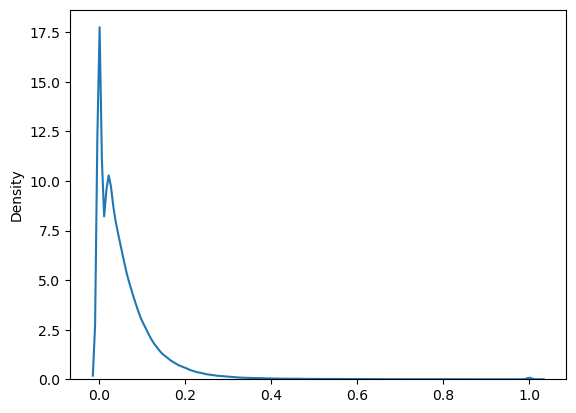

In [18]:

# normalized_scores.flatten().shape
bm25_normalized_scores = pd.Series(normalized_scores.flatten())
# sns.histplot(normalized_scores.flatten())
sns.kdeplot(normalized_scores.flatten())
print(f"max bm25 normalized Score = {normalized_scores.flatten().max()}")
print(f"min bm25 normalized Score = {normalized_scores.flatten().min()}")
print(f"mean bm25 normalized Score = {normalized_scores.flatten().mean()}")
print(f"std bm25 normalized Score = {normalized_scores.flatten().std()}")
bm25_normalized_scores.describe(percentiles=[.1,.25,.5,.75,.9,.95,.99,.995,.9975,.999])



This looks more like a power distribution rather than a normal distribution that we were expecting.

## Extract related controls from the normalized BM25 scores

For the final step for the BM25 section, we will determine a score threshold and take every regulation pair with a score above that threshold as related.

Similar to the original "Related Controls" listing, we will make the relations relate to the main control, even if the similar regulation is a sub-control(the relation will go to its main control).

As additional data, we are saving the relations scores, so we may use them to calculate the weights for the network analysis.


In [19]:

# what is the minimal score for a control to be considered related
# # a hardcoded threshold
# minimal_related_bm25_score: float = 0.5
# # a threshold as a quantile of the scores distribution
# minimal_related_bm25_score: float = bm25_normalized_scores.quantile(.99)
# a threshold as the number of expected relations
n = 7 # number of expected relations
minimal_related_bm25_score: float = bm25_normalized_scores.quantile(1-n/normalized_scores.shape[1])

# set a minimal number of relations wanted per regulation (that are different from the main)
min_relations_per_regulation: int = 1


# add a column for the bm25 Related Controls
Active_NIS_regulations.loc[:,"normalized bm25 Related Controls"] = None

# go over every regulation
for i in range(normalized_scores.shape[0]):
    # go over all the other regulations to check if they are related
    # related_regulations:list = []
    regulations_scores:dict = {}
    related_regulations:dict = {}
    for j in range(normalized_scores.shape[1]):
        if i == results[i,j]:
            continue
        else:
            key = (Active_NIS_regulations.iloc[results[i,j],:]["Main Control Name"],Active_NIS_regulations.iloc[results[i,j],:]["Control Identifier"])
            # if key[0] != Active_NIS_regulations.iloc[i,:]["Main Control Name"]:
            if key[1] != Active_NIS_regulations.iloc[i,:]["Control Identifier"]:
                if key not in regulations_scores:
                    regulations_scores[key] = normalized_scores[i,j]
                elif normalized_scores[i,j] > regulations_scores[key]:
                    regulations_scores[key] = normalized_scores[i,j]

    regulations_scores = dict(sorted(regulations_scores.items(), key=lambda item: item[1], reverse=True))

    out_regulations:int = 0
    for k, v in regulations_scores.items():
        if out_regulations >= min_relations_per_regulation and v <  minimal_related_bm25_score:
            break
        else:
            related_regulations[k[1]] = v
            if k[0] != Active_NIS_regulations.iloc[i,:]["Main Control Name"]:
                out_regulations += 1
    
    Active_NIS_regulations.at[Active_NIS_regulations.iloc[i,:].name, "normalized bm25 Related Controls"] = related_regulations
    print(f"Regulation {i} ({Active_NIS_regulations.iloc[i,0]}) has related regulations: {related_regulations}")
    # print(related_regulations)
    # break



C:\Users\User\AppData\Local\Temp\ipykernel_20376\2730603821.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_NIS_regulations.loc[:,"normalized bm25 Related Controls"] = None


Regulation 0 (AC-1) has related regulations: {'MA-1': 0.8947177027189795, 'PL-1': 0.8947177027189795, 'CM-1': 0.8861444455422218, 'IR-1': 0.8814744201375047, 'PS-1': 0.8803086842401626, 'MP-1': 0.8674467257485824, 'AT-1': 0.8674467257485824, 'CP-1': 0.8674467257485824, 'AU-1': 0.8674467257485824, 'RA-1': 0.8674467257485824, 'IA-1': 0.8674467257485824, 'SI-1': 0.845565816319128, 'SC-1': 0.845565816319128, 'SA-1': 0.845565816319128, 'PE-1': 0.8418879359720983, 'CA-1': 0.8418879359720983, 'SR-1': 0.8364852593452902, 'PT-1': 0.8052717839518925, 'PM-17': 0.5273192254359462, 'AC-3(15)': 0.39999302182097307, 'AC-3(7)': 0.3879384190670566}
Regulation 1 (AC-2) has related regulations: {'AC-2(3)': 0.5456564097423026, 'AC-2(7)': 0.5332102684763498, 'AC-2(9)': 0.5220074162177839, 'AC-2(12)': 0.5073050386463656, 'AC-2(2)': 0.497907489534503, 'AC-2(13)': 0.4820235309761175, 'IA-2(5)': 0.4703392514575003, 'IA-5': 0.46017980787930934, 'AC-2(8)': 0.4444947807971446, 'AC-6(2)': 0.44144730108880953, 'AC-

In [20]:

normalized_scores.shape[0]
normalized_scores[10,:10]
Active_NIS_regulations.iloc[0,:]
# bm25_normalized_scores.quantile(.99)
# n = 7
# 1-n/normalized_scores.shape[1]
# bm25_normalized_scores.quantile(1-n/normalized_scores.shape[1])


Control Identifier                                                                    AC-1
Control (or Control Enhancement) Name                                Policy and Procedures
Control Text                             a. Develop, document, and disseminate to [Assi...
Discussion                               Access control policy and procedures address t...
Related Controls                                          IA-1, PM-9, PM-24, PS-8, SI-12 .
Main Control Name                                                                     AC-1
Family Name                                                                             AC
Related Controls Dictionary              {'IA-1': 0.5, 'PM-9': 0.5, 'PM-24': 0.5, 'PS-8...
Full Text                                Policy and Procedures\n\na. Develop, document,...
bm25 Related Controls                    {'MA-1': 59.279785, 'PL-1': 59.279785, 'CM-1':...
normalized bm25 Related Controls         {'MA-1': 0.8947177027189795, 'PL-1': 0.8947177...

# Make SentenceTransformer embeddings

We are taking an open-source Sentence Transformers model as a free and available option for the embedding task because it is a good free option for embedding that anyone can use.



## Chose a good embedding model and embed
Use the best small (<1B) embedder form [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard)

We want to use a small model because it will be able to run on most normal machines (we don't want to use models that will take more RAM than some machines can spare).

In [21]:

# This model supports two prompts: "s2p_query" and "s2s_query" for sentence-to-passage and sentence-to-sentence tasks, respectively.
# They are defined in `config_sentence_transformers.json`
query_prompt_name = "s2p_query"
queries = [
    "What are some ways to reduce stress?",
    "What are the benefits of drinking green tea?",
]
# docs do not need any prompts
docs = [
    "There are many effective ways to reduce stress. Some common techniques include deep breathing, meditation, and physical activity. Engaging in hobbies, spending time in nature, and connecting with loved ones can also help alleviate stress. Additionally, setting boundaries, practicing self-care, and learning to say no can prevent stress from building up.",
    "Green tea has been consumed for centuries and is known for its potential health benefits. It contains antioxidants that may help protect the body against damage caused by free radicals. Regular consumption of green tea has been associated with improved heart health, enhanced cognitive function, and a reduced risk of certain types of cancer. The polyphenols in green tea may also have anti-inflammatory and weight loss properties.",
]

# ！The default dimension is 1024, if you need other dimensions, please clone the model and modify `modules.json` to replace `2_Dense_1024` with another dimension, e.g. `2_Dense_256` or `2_Dense_8192` !
# on gpu
# model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True).cuda()
# you can also use this model without the features of `use_memory_efficient_attention` and `unpad_inputs`. It can be worked in CPU.
model = SentenceTransformer(
    "dunzhang/stella_en_400M_v5",
    trust_remote_code=True,
    device="cpu",
    config_kwargs={"use_memory_efficient_attention": False, "unpad_inputs": False}
)
query_embeddings = model.encode(queries, prompt_name=query_prompt_name)
doc_embeddings = model.encode(docs)
print(query_embeddings.shape, doc_embeddings.shape)
# (2, 1024) (2, 1024)

similarities = model.similarity(query_embeddings, doc_embeddings)
print(similarities)
# tensor([[0.8398, 0.2990],
#         [0.3282, 0.8095]])



Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: {'new.pooler.dense.weight', 'new.pooler.dense.bias'}
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\User\anaconda3\envs\lior1\Lib\site-packages\transformers\modeling_utils.py:1072: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


(2, 1024) (2, 1024)
tensor([[0.8398, 0.2990],
        [0.3282, 0.8095]])


In [22]:
queries = Active_NIS_regulations.loc[:,"Full Text"].to_list()
queries[:5]

['Policy and Procedures\n\na. Develop, document, and disseminate to [Assignment: organization-defined personnel or roles]:\n1. [Selection (one or more): Organization-level; Mission/business process-level; System-level] access control policy that:\n(a) Addresses purpose, scope, roles, responsibilities, management commitment, coordination among organizational entities, and compliance; and\n(b) Is consistent with applicable laws, executive orders, directives, regulations, policies, standards, and guidelines; and\n2. Procedures to facilitate the implementation of the access control policy and the associated access controls;\nb. Designate an [Assignment: organization-defined official] to manage the development, documentation, and dissemination of the access control policy and procedures; and\nc. Review and update the current access control:\n1. Policy [Assignment: organization-defined frequency] and following [Assignment: organization-defined events]; and\n2. Procedures [Assignment: organiz

In [23]:

# This model supports two prompts: "s2p_query" and "s2s_query" for sentence-to-passage and sentence-to-sentence tasks, respectively.
# They are defined in `config_sentence_transformers.json`
query_prompt_name = "s2s_query"
queries = Active_NIS_regulations.loc[:,"Full Text"].to_list()

# ！The default dimension is 1024, if you need other dimensions, please clone the model and modify `modules.json` to replace `2_Dense_1024` with another dimension, e.g. `2_Dense_256` or `2_Dense_8192` !
# on gpu
# model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True).cuda()
# you can also use this model without the features of `use_memory_efficient_attention` and `unpad_inputs`. It can be worked in CPU.
model = SentenceTransformer(
    "dunzhang/stella_en_400M_v5",
    trust_remote_code=True,
    device="cpu",
    config_kwargs={"use_memory_efficient_attention": False, "unpad_inputs": False}
)
query_embeddings = model.encode(queries, prompt_name=query_prompt_name)
print(query_embeddings.shape)

SentenceTransformer_similarities = model.similarity(query_embeddings, query_embeddings)
print(SentenceTransformer_similarities)



Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: {'new.pooler.dense.weight', 'new.pooler.dense.bias'}
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(1007, 1024)
tensor([[1.0000, 0.7612, 0.6293,  ..., 0.6526, 0.6015, 0.6547],
        [0.7612, 1.0000, 0.7877,  ..., 0.6545, 0.6002, 0.6386],
        [0.6293, 0.7877, 1.0000,  ..., 0.6630, 0.6188, 0.6187],
        ...,
        [0.6526, 0.6545, 0.6630,  ..., 1.0000, 0.7470, 0.6772],
        [0.6015, 0.6002, 0.6188,  ..., 0.7470, 1.0000, 0.6462],
        [0.6547, 0.6386, 0.6187,  ..., 0.6772, 0.6462, 1.0000]])


What is the distribution of the SentenceTransformer scores?


max SentenceTransformer Score = 1.0000007152557373
min SentenceTransformer Score = 0.4002190828323364
mean SentenceTransformer Score = 0.5936755537986755
std SentenceTransformer Score = 0.061557259410619736


count     1.014049e+06
mean      5.936755e-01
std       6.154253e-02
min       4.002191e-01
10%       5.197783e-01
25%       5.514804e-01
50%       5.897334e-01
75%       6.302466e-01
90%       6.697699e-01
95%       6.961381e-01
99%       7.612001e-01
99.5%     7.999417e-01
99.75%    8.654743e-01
99.9%     9.759435e-01
max       1.000001e+00
dtype: float64

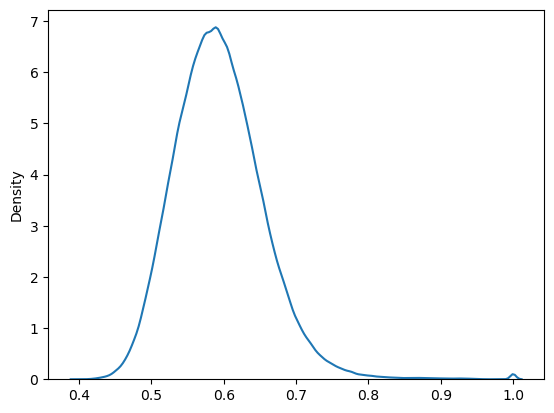

In [24]:

# SentenceTransformer_similarities = model.similarity(query_embeddings, query_embeddings)
# print(SentenceTransformer_similarities)

# # normalize to (0,1)
# SentenceTransformer_similarities = (SentenceTransformer_similarities - SentenceTransformer_similarities.flatten().min()) / (SentenceTransformer_similarities.flatten().max() - SentenceTransformer_similarities.flatten().min())


# SentenceTransformer_similarities.flatten().shape
SentenceTransformer_scores = pd.Series(SentenceTransformer_similarities.flatten())
# sns.histplot(SentenceTransformer_similarities.flatten())
sns.kdeplot(SentenceTransformer_similarities.flatten())
print(f"max SentenceTransformer Score = {SentenceTransformer_similarities.flatten().max()}")
print(f"min SentenceTransformer Score = {SentenceTransformer_similarities.flatten().min()}")
print(f"mean SentenceTransformer Score = {SentenceTransformer_similarities.flatten().mean()}")
print(f"std SentenceTransformer Score = {SentenceTransformer_similarities.flatten().std()}")
SentenceTransformer_scores.describe(percentiles=[.1,.25,.5,.75,.9,.95,.99,.995,.9975,.999])




This looks like a normal distribution, like we would expect.


## Extract related controls from the SentenceTransformer scores

For the final step for the SentenceTransformer section, we will determine a score threshold and take every regulation pair with a score above that threshold as related, and we will also do post-processing similar to the BM25 section.


In [25]:


# what is the minimal score for a control to be considered related
# # a hardcoded threshold
# minimal_related_SentenceTransformer_score: float = 0.5
# # a threshold as a quantile of the scores distribution
# minimal_related_SentenceTransformer_score: float = SentenceTransformer_scores.quantile(.99)
# a threshold as the number of expected relations
n = 7 # number of expected relations
minimal_related_SentenceTransformer_score: float = SentenceTransformer_scores.quantile(1-n/SentenceTransformer_similarities.shape[1])

# set a minimal number of relations wanted per regulation (that are different from the main)
min_relations_per_regulation: int = 1


# add a column for the SentenceTransformer Related Controls
Active_NIS_regulations.loc[:,"SentenceTransformer Related Controls"] = None

# go over every regulation
for i in range(SentenceTransformer_similarities.shape[0]):
    # go over all the other regulations to check if they are related
    # related_regulations:list = []
    regulations_scores:dict = {}
    related_regulations:dict = {}
    for j in range(SentenceTransformer_similarities.shape[1]):
        if i == j:
            continue
        else:
            key = (Active_NIS_regulations.iloc[j,:]["Main Control Name"],Active_NIS_regulations.iloc[j,:]["Control Identifier"])
            # if key[0] != Active_NIS_regulations.iloc[i,:]["Main Control Name"]:
            if key[1] != Active_NIS_regulations.iloc[i,:]["Control Identifier"]:
                if key not in regulations_scores:
                    regulations_scores[key] = SentenceTransformer_similarities[i,j].item()
                elif SentenceTransformer_similarities[i,j].item() > regulations_scores[key]:
                    regulations_scores[key] = SentenceTransformer_similarities[i,j].item()

    regulations_scores = dict(sorted(regulations_scores.items(), key=lambda item: item[1], reverse=True))

    out_regulations:int = 0
    for k, v in regulations_scores.items():
        if out_regulations >= min_relations_per_regulation and v <  minimal_related_SentenceTransformer_score:
            break
        else:
            related_regulations[k[1]] = v
            if k[0] != Active_NIS_regulations.iloc[i,:]["Main Control Name"]:
                out_regulations += 1
    
    related_regulations = dict(sorted(related_regulations.items(), key=lambda item: item[1], reverse=True))
    Active_NIS_regulations.at[Active_NIS_regulations.iloc[i,:].name, "SentenceTransformer Related Controls"] = related_regulations
    print(f"Regulation {i} ({Active_NIS_regulations.iloc[i,0]}) has related regulations: {related_regulations}")
    # print(related_regulations)
    # break






C:\Users\User\AppData\Local\Temp\ipykernel_20376\1069512614.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_NIS_regulations.loc[:,"SentenceTransformer Related Controls"] = None


Regulation 0 (AC-1) has related regulations: {'PS-1': 0.9554650783538818, 'CA-1': 0.9547804594039917, 'IA-1': 0.9510162472724915, 'CM-1': 0.9493938088417053, 'SC-1': 0.9479312896728516, 'PL-1': 0.9473742842674255, 'SI-1': 0.9469489455223083, 'AU-1': 0.9451122283935547, 'SA-1': 0.9437251687049866, 'MA-1': 0.9436460733413696, 'PT-1': 0.9396622776985168, 'IR-1': 0.9388549327850342, 'RA-1': 0.9380010962486267, 'MP-1': 0.9376986026763916, 'CP-1': 0.9338691234588623, 'AT-1': 0.9337183833122253, 'PE-1': 0.9227429628372192, 'SR-1': 0.9149220585823059, 'PM-17': 0.8009781241416931, 'AC-3(15)': 0.8003402352333069, 'PM-18': 0.7983064651489258, 'PL-2': 0.7894600629806519, 'AC-3(4)': 0.7873464226722717, 'AC-3(7)': 0.7871884107589722, 'CM-9': 0.786575973033905, 'PM-1': 0.7824552059173584}
Regulation 1 (AC-2) has related regulations: {'AC-2(7)': 0.8722906112670898, 'AC-2(11)': 0.8390557169914246, 'IA-5': 0.8381967544555664, 'AC-2(8)': 0.8314058184623718, 'AC-2(9)': 0.8272772431373596, 'AC-2(6)': 0.808

In [26]:

SentenceTransformer_similarities[0,1].item()
related_regulations
dict(sorted(related_regulations.items(), key=lambda item: item[1], reverse=True))
SentenceTransformer_similarities.shape[1]



1007

# Make SaaS embeddings
Use Google GanAI embedding service, google GanAI was chosen for the embeddings because the [Google AI Studio](https://aistudio.google.com/app/) gives a free and simple service that we can use for our embedding needs.

## Chose a good embedding model and embed

We will use the least and best text embedding model.

In [27]:

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

for model in genai.list_models():
  if 'embedContent' in model.supported_generation_methods:
    print(model.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [28]:

# texts = corpus[:5]
texts = Active_NIS_regulations.loc[:,"Full Text"].to_list()

response = genai.embed_content(model='models/text-embedding-004',
                               content=texts,
                               task_type='semantic_similarity')


In [29]:
def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

truncated_texts = [truncate(t) for t in texts]

,"Policy and Procedures\n\na. Develop, document, an...",Account Management\n\na. Define and document the ...,Account Management | Automated System Account M...,Account Management | Automated Temporary and Em...,Account Management | Disable Accounts\n\nDisable ...,Account Management | Automated Audit Actions\n\nA...,Account Management | Inactivity Logout\n\nRequire...,Account Management | Dynamic Privilege Manageme...,Account Management | Privileged User Accounts\n\n...,Account Management | Dynamic Account Management...
"Policy and Procedures\n\na. Develop, document, an...",0.999959,0.783736,0.685513,0.596052,0.643221,0.635551,0.645214,0.727812,0.737687,0.630275
Account Management\n\na. Define and document the ...,0.783736,0.999921,0.834854,0.776776,0.819282,0.796817,0.748042,0.805476,0.869022,0.817774
Account Management | Automated System Account M...,0.685513,0.834854,0.999997,0.776646,0.704068,0.788786,0.651434,0.796890,0.792925,0.838514
Account Management | Automated Temporary and Em...,0.596052,0.776776,0.776646,0.999995,0.832705,0.765691,0.719395,0.725999,0.706531,0.792118
Account Management | Disable Accounts\n\nDisable ...,0.643221,0.819282,0.704068,0.832705,0.999989,0.719822,0.785171,0.709542,0.756364,0.754536
Account Management | Automated Audit Actions\n\nA...,0.635551,0.796817,0.788786,0.765691,0.719822,0.999997,0.622610,0.738360,0.782116,0.799806
Account Management | Inactivity Logout\n\nRequire...,0.645214,0.748042,0.651434,0.719395,0.785171,0.622610,0.999996,0.683747,0.678268,0.652666
Account Management | Dynamic Privilege Manageme...,0.727812,0.805476,0.796890,0.725999,0.709542,0.738360,0.683747,0.999998,0.827728,0.848916
Account Management | Privileged User Accounts\n\n...,0.737687,0.869022,0.792925,0.706531,0.756364,0.782116,0.678268,0.827728,0.999989,0.765733
Account Management | Dynamic Account Management...,0.630275,0.817774,0.838514,0.792118,0.754536,0.799806,0.652666,0.848916,0.765733,0.999996


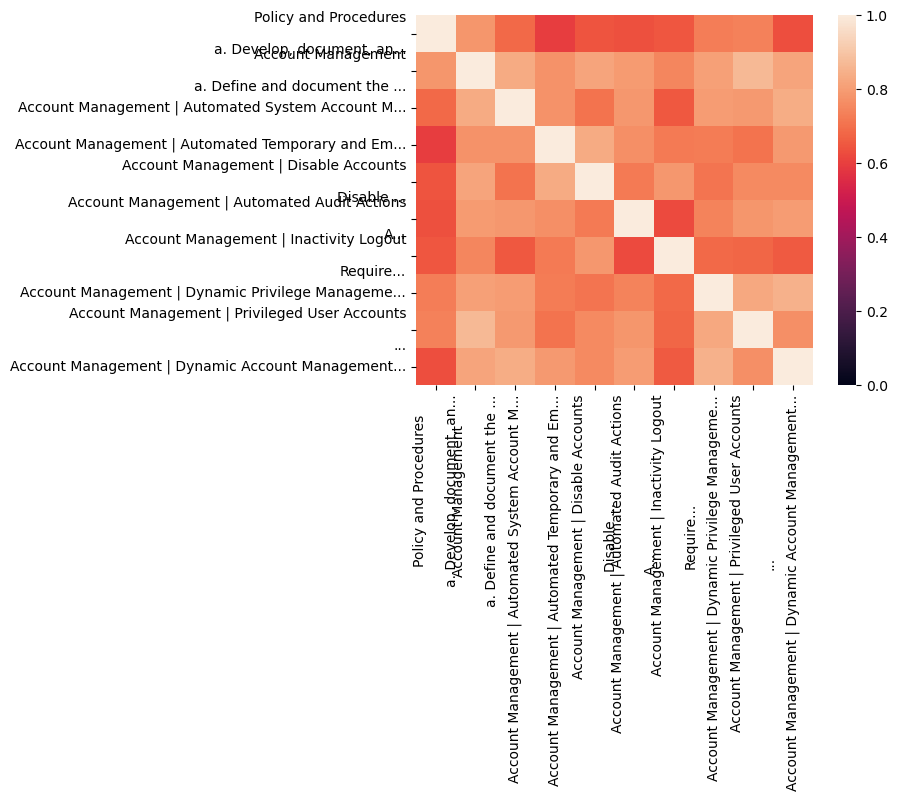

In [30]:

# small scale sample

# Set up the embeddings in a dataframe.
df = pd.DataFrame(response['embedding'], index=truncated_texts)
# Perform the similarity calculation
sim = df @ df.T
# Draw!
sns.heatmap(sim.iloc[:10,:10], vmin=0, vmax=1)
sim.iloc[:10,:10]


What is the distribution of the SaaS scores?

max SaaS Score = 0.9999988680347752
min SaaS Score = 0.37685151585065557
mean SaaS Score = 0.6327340765955719
std SaaS Score = 0.06400476638593972


count     1.014049e+06
mean      6.327341e-01
std       6.400480e-02
min       3.768515e-01
10%       5.529555e-01
25%       5.896739e-01
50%       6.312641e-01
75%       6.730189e-01
90%       7.116534e-01
95%       7.363882e-01
99%       7.964514e-01
99.5%     8.298782e-01
99.75%    8.755882e-01
99.9%     9.751884e-01
max       9.999989e-01
dtype: float64

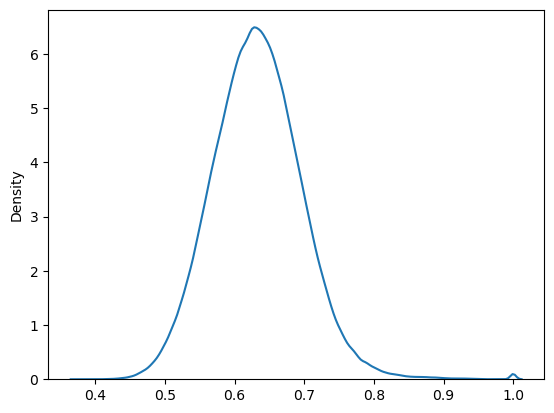

In [31]:


SaaS_similarities = sim.to_numpy()
# # normalize to (0,1)
# SaaS_similarities = (SaaS_similarities - SaaS_similarities.flatten().min()) / (SaaS_similarities.flatten().max() - SaaS_similarities.flatten().min())

# SaaS_similarities.flatten().shape
SaaS_scores = pd.Series(SaaS_similarities.flatten())
# sns.histplot(SaaS_similarities.flatten())
sns.kdeplot(SaaS_similarities.flatten())
print(f"max SaaS Score = {SaaS_similarities.flatten().max()}")
print(f"min SaaS Score = {SaaS_similarities.flatten().min()}")
print(f"mean SaaS Score = {SaaS_similarities.flatten().mean()}")
print(f"std SaaS Score = {SaaS_similarities.flatten().std()}")
SaaS_scores.describe(percentiles=[.1,.25,.5,.75,.9,.95,.99,.995,.9975,.999])




This looks like a normal distribution, like we would expect.

## Extract related controls from the SaaS scores

For the final step for the SaaS section, we will determine a score threshold and take every regulation pair with a score above that threshold as related, and we will also do post-processing similar to the BM25 and SentenceTransformer sections.


In [32]:


# what is the minimal score for a control to be considered related
# # a hardcoded threshold
# minimal_related_SaaS_score: float = 0.5
# # a threshold as a quantile of the scores distribution
# minimal_related_SaaS_score: float = SaaS_scores.quantile(.99)
# a threshold as the number of expected relations
n = 7 # number of expected relations
minimal_related_SaaS_score: float = SaaS_scores.quantile(1-n/SaaS_similarities.shape[1])

# set a minimal number of relations wanted per regulation (that are different from the main)
min_relations_per_regulation: int = 1


# add a column for the SaaS Related Controls
Active_NIS_regulations.loc[:,"SaaS Related Controls"] = None

# go over every regulation
for i in range(SaaS_similarities.shape[0]):
    # go over all the other regulations to check if they are related
    # related_regulations:list = []
    regulations_scores:dict = {}
    related_regulations:dict = {}
    for j in range(SaaS_similarities.shape[1]):
        if i == j:
            continue
        else:
            key = (Active_NIS_regulations.iloc[j,:]["Main Control Name"],Active_NIS_regulations.iloc[j,:]["Control Identifier"])
            # if key[0] != Active_NIS_regulations.iloc[i,:]["Main Control Name"]:
            if key[1] != Active_NIS_regulations.iloc[i,:]["Control Identifier"]:
                if key not in regulations_scores:
                    regulations_scores[key] = SaaS_similarities[i,j].item()
                elif SaaS_similarities[i,j].item() > regulations_scores[key]:
                    regulations_scores[key] = SaaS_similarities[i,j].item()

    regulations_scores = dict(sorted(regulations_scores.items(), key=lambda item: item[1], reverse=True))

    out_regulations:int = 0
    for k, v in regulations_scores.items():
        if out_regulations >= min_relations_per_regulation and v <  minimal_related_SaaS_score:
            break
        else:
            related_regulations[k[1]] = v
            if k[0] != Active_NIS_regulations.iloc[i,:]["Main Control Name"]:
                out_regulations += 1
    
    related_regulations = dict(sorted(related_regulations.items(), key=lambda item: item[1], reverse=True))
    Active_NIS_regulations.at[Active_NIS_regulations.iloc[i,:].name, "SaaS Related Controls"] = related_regulations
    print(f"Regulation {i} ({Active_NIS_regulations.iloc[i,0]}) has related regulations: {related_regulations}")
    # print(related_regulations)
    # break




C:\Users\User\AppData\Local\Temp\ipykernel_20376\2116307414.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_NIS_regulations.loc[:,"SaaS Related Controls"] = None


Regulation 0 (AC-1) has related regulations: {'CA-1': 0.9555830106820367, 'SC-1': 0.9506337540263092, 'PS-1': 0.950139034532604, 'IA-1': 0.9433262866960146, 'SI-1': 0.9429564565962818, 'AU-1': 0.9407610350576225, 'PL-1': 0.9373220718620325, 'RA-1': 0.9359978956442284, 'CM-1': 0.931933541992275, 'SA-1': 0.9307049720572087, 'AT-1': 0.9300006787133108, 'MP-1': 0.9299980144604996, 'MA-1': 0.9297985016335292, 'PE-1': 0.9278253604512812, 'CP-1': 0.9266664519506163, 'IR-1': 0.9263953417707502, 'SR-1': 0.9217372405386126, 'PT-1': 0.9198076335048287, 'PM-1': 0.8537291032496708, 'PS-6': 0.8497113984592382, 'PM-17': 0.8449044644379837, 'PM-18': 0.8416750267654811, 'PL-2': 0.8317797415249137, 'PL-4': 0.8267371202970233, 'SA-5': 0.8183020101710419, 'PM-9': 0.817993217307679, 'AC-24': 0.8131593206230536}
Regulation 1 (AC-2) has related regulations: {'AC-2(7)': 0.8690222363681739, 'AC-2(11)': 0.8636625797794719, 'AC-2(1)': 0.8348540789805953, 'AC-2(12)': 0.8252638154283891, 'AC-2(3)': 0.8192816914571

In [33]:

SaaS_similarities[2,251]
print(f"SaaS_similarities[2,251] = {SaaS_similarities[2,251]}")
SaaS_similarities[251,2]

print(f"SaaS_similarities[251,2] = {SaaS_similarities[251,2]}")

print(SaaS_similarities[2,251]==SaaS_similarities[251,2])


SaaS_similarities[2,251] = 0.8248141352339295
SaaS_similarities[251,2] = 0.8248141352339295
True


In [34]:
Active_NIS_regulations




,Control Identifier,Control (or Control Enhancement) Name,Control Text,Discussion,Related Controls,Main Control Name,Family Name,Related Controls Dictionary,Full Text,bm25 Related Controls,normalized bm25 Related Controls,SentenceTransformer Related Controls,SaaS Related Controls
0,AC-1,Policy and Procedures,"a. Develop, document, and disseminate to [Assi...",Access control policy and procedures address t...,"IA-1, PM-9, PM-24, PS-8, SI-12 .",AC-1,AC,"{'IA-1': 0.5, 'PM-9': 0.5, 'PM-24': 0.5, 'PS-8...","Policy and Procedures\n\na. Develop, document,...","{'MA-1': 59.279785, 'PL-1': 59.279785, 'CM-1':...","{'MA-1': 0.8947177027189795, 'PL-1': 0.8947177...","{'PS-1': 0.9554650783538818, 'CA-1': 0.9547804...","{'CA-1': 0.9555830106820367, 'SC-1': 0.9506337..."
1,AC-2,Account Management,a. Define and document the types of accounts a...,Examples of system account types include indiv...,"AC-3, AC-5, AC-6, AC-17, AC-18, AC-20, AC-24, ...",AC-2,AC,"{'AC-3': 0.5, 'AC-5': 0.5, 'AC-6': 0.5, 'AC-17...",Account Management\n\na. Define and document t...,"{'AC-2(3)': 63.617912, 'AC-2(7)': 62.16682, 'A...","{'AC-2(3)': 0.5456564097423026, 'AC-2(7)': 0.5...","{'AC-2(7)': 0.8722906112670898, 'AC-2(11)': 0....","{'AC-2(7)': 0.8690222363681739, 'AC-2(11)': 0...."
2,AC-2(1),Account Management | Automated System Account ...,Support the management of system accounts usin...,Automated system account management includes u...,None.,AC-2,AC,{},Account Management | Automated System Account ...,"{'AC-2(2)': 13.920116, 'AC-2(8)': 13.007392, '...","{'AC-2(2)': 0.6856685718365872, 'AC-2(8)': 0.6...","{'AC-2(8)': 0.8399572968482971, 'IR-4(1)': 0.8...","{'AC-2(8)': 0.8385143606316967, 'AC-2(11)': 0...."
3,AC-2(2),Account Management | Automated Temporary and E...,Automatically [Selection: remove; disable] tem...,Management of temporary and emergency accounts...,None.,AC-2,AC,{},Account Management | Automated Temporary and E...,"{'AC-2(4)': 18.166128, 'AC-2(3)': 16.502178, '...","{'AC-2(4)': 0.4500737751259309, 'AC-2(3)': 0.4...","{'AC-2(3)': 0.8158748745918274, 'AC-2(4)': 0.8...","{'AC-2(3)': 0.8327054165938192, 'AC-2(13)': 0...."
4,AC-2(3),Account Management | Disable Accounts,Disable accounts within [Assignment: organizat...,"Disabling expired, inactive, or otherwise anom...",None.,AC-2,AC,{},Account Management | Disable Accounts\n\nDisab...,"{'AC-2(13)': 23.608458, 'AC-2(2)': 20.140789, ...","{'AC-2(13)': 0.5667917968522473, 'AC-2(2)': 0....","{'AC-2(13)': 0.8616950511932373, 'AC-2(5)': 0....","{'AC-2(13)': 0.8635755082149525, 'AC-2(2)': 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,SR-11,Component Authenticity,a. Develop and implement anti-counterfeit poli...,Sources of counterfeit components include manu...,"PE-3, SA-4, SI-7, SR-9, SR-10.",SR-11,SR,"{'PE-3': 0.5, 'SA-4': 0.5, 'SI-7': 0.5, 'SR-9'...",Component Authenticity\n\na. Develop and imple...,"{'SR-11(1)': 28.726461, 'SR-11(3)': 26.127123,...","{'SR-11(1)': 0.6496216599515963, 'SR-11(3)': 0...","{'SR-11(1)': 0.8409212231636047, 'SR-11(3)': 0...","{'SR-11(1)': 0.8345096504298886, 'CM-8(3)': 0...."
1185,SR-11(1),Component Authenticity | Anti-counterfeit Trai...,Train [Assignment: organization-defined person...,None.,AT-3.,SR-11,SR,{'AT-3': 0.5},Component Authenticity | Anti-counterfeit Trai...,"{'SR-11': 17.023554, 'SR-11(3)': 15.025012, 'C...","{'SR-11': 0.6172898806384338, 'SR-11(3)': 0.54...","{'SR-11(3)': 0.8443235158920288, 'SR-11': 0.84...","{'SR-11(3)': 0.8393997564526279, 'SR-11': 0.83..."
1186,SR-11(2),Component Authenticity | Configuration Control...,Maintain configuration control over the follow...,None.,"CM-3, MA-2, MA-4, SA-10.",SR-11,SR,"{'CM-3': 0.5, 'MA-2': 0.5, 'MA-4': 0.5, 'SA-10...",Component Authenticity | Configuration Control...,{'SA-4(5)': 16.491982},{'SA-4(5)': 0.37485503792576363},"{'MA-2': 0.8005739450454712, 'CM-8(2)': 0.7839...","{'SR-4': 0.8314977910120207, 'MA-2': 0.8313986..."
1187,SR-11(3),Component Authenticity | Anti-counterfeit Scan...,Scan for co

# Save the new Related Controls columns data

Now after we have done all of the embeddings and extracted the wanted relationships we will save the results for the next step of the process.

In [35]:


Active_NIS_regulations.to_feather(f"regulations//Active_NIS_regulations_with_new_related_controls2M+{min_relations_per_regulation}.feather")
Active_NIS_regulations.to_parquet(f"regulations//Active_NIS_regulations_with_new_related_controls2M+{min_relations_per_regulation}.parquet", compression=None)
Active_NIS_regulations


,Control Identifier,Control (or Control Enhancement) Name,Control Text,Discussion,Related Controls,Main Control Name,Family Name,Related Controls Dictionary,Full Text,bm25 Related Controls,normalized bm25 Related Controls,SentenceTransformer Related Controls,SaaS Related Controls
0,AC-1,Policy and Procedures,"a. Develop, document, and disseminate to [Assi...",Access control policy and procedures address t...,"IA-1, PM-9, PM-24, PS-8, SI-12 .",AC-1,AC,"{'IA-1': 0.5, 'PM-9': 0.5, 'PM-24': 0.5, 'PS-8...","Policy and Procedures\n\na. Develop, document,...","{'MA-1': 59.279785, 'PL-1': 59.279785, 'CM-1':...","{'MA-1': 0.8947177027189795, 'PL-1': 0.8947177...","{'PS-1': 0.9554650783538818, 'CA-1': 0.9547804...","{'CA-1': 0.9555830106820367, 'SC-1': 0.9506337..."
1,AC-2,Account Management,a. Define and document the types of accounts a...,Examples of system account types include indiv...,"AC-3, AC-5, AC-6, AC-17, AC-18, AC-20, AC-24, ...",AC-2,AC,"{'AC-3': 0.5, 'AC-5': 0.5, 'AC-6': 0.5, 'AC-17...",Account Management\n\na. Define and document t...,"{'AC-2(3)': 63.617912, 'AC-2(7)': 62.16682, 'A...","{'AC-2(3)': 0.5456564097423026, 'AC-2(7)': 0.5...","{'AC-2(7)': 0.8722906112670898, 'AC-2(11)': 0....","{'AC-2(7)': 0.8690222363681739, 'AC-2(11)': 0...."
2,AC-2(1),Account Management | Automated System Account ...,Support the management of system accounts usin...,Automated system account management includes u...,None.,AC-2,AC,{},Account Management | Automated System Account ...,"{'AC-2(2)': 13.920116, 'AC-2(8)': 13.007392, '...","{'AC-2(2)': 0.6856685718365872, 'AC-2(8)': 0.6...","{'AC-2(8)': 0.8399572968482971, 'IR-4(1)': 0.8...","{'AC-2(8)': 0.8385143606316967, 'AC-2(11)': 0...."
3,AC-2(2),Account Management | Automated Temporary and E...,Automatically [Selection: remove; disable] tem...,Management of temporary and emergency accounts...,None.,AC-2,AC,{},Account Management | Automated Temporary and E...,"{'AC-2(4)': 18.166128, 'AC-2(3)': 16.502178, '...","{'AC-2(4)': 0.4500737751259309, 'AC-2(3)': 0.4...","{'AC-2(3)': 0.8158748745918274, 'AC-2(4)': 0.8...","{'AC-2(3)': 0.8327054165938192, 'AC-2(13)': 0...."
4,AC-2(3),Account Management | Disable Accounts,Disable accounts within [Assignment: organizat...,"Disabling expired, inactive, or otherwise anom...",None.,AC-2,AC,{},Account Management | Disable Accounts\n\nDisab...,"{'AC-2(13)': 23.608458, 'AC-2(2)': 20.140789, ...","{'AC-2(13)': 0.5667917968522473, 'AC-2(2)': 0....","{'AC-2(13)': 0.8616950511932373, 'AC-2(5)': 0....","{'AC-2(13)': 0.8635755082149525, 'AC-2(2)': 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,SR-11,Component Authenticity,a. Develop and implement anti-counterfeit poli...,Sources of counterfeit components include manu...,"PE-3, SA-4, SI-7, SR-9, SR-10.",SR-11,SR,"{'PE-3': 0.5, 'SA-4': 0.5, 'SI-7': 0.5, 'SR-9'...",Component Authenticity\n\na. Develop and imple...,"{'SR-11(1)': 28.726461, 'SR-11(3)': 26.127123,...","{'SR-11(1)': 0.6496216599515963, 'SR-11(3)': 0...","{'SR-11(1)': 0.8409212231636047, 'SR-11(3)': 0...","{'SR-11(1)': 0.8345096504298886, 'CM-8(3)': 0...."
1185,SR-11(1),Component Authenticity | Anti-counterfeit Trai...,Train [Assignment: organization-defined person...,None.,AT-3.,SR-11,SR,{'AT-3': 0.5},Component Authenticity | Anti-counterfeit Trai...,"{'SR-11': 17.023554, 'SR-11(3)': 15.025012, 'C...","{'SR-11': 0.6172898806384338, 'SR-11(3)': 0.54...","{'SR-11(3)': 0.8443235158920288, 'SR-11': 0.84...","{'SR-11(3)': 0.8393997564526279, 'SR-11': 0.83..."
1186,SR-11(2),Component Authenticity | Configuration Control...,Maintain configuration control over the follow...,None.,"CM-3, MA-2, MA-4, SA-10.",SR-11,SR,"{'CM-3': 0.5, 'MA-2': 0.5, 'MA-4': 0.5, 'SA-10...",Component Authenticity | Configuration Control...,{'SA-4(5)': 16.491982},{'SA-4(5)': 0.37485503792576363},"{'MA-2': 0.8005739450454712, 'CM-8(2)': 0.7839...","{'SR-4': 0.8314977910120207, 'MA-2': 0.8313986..."
1187,SR-11(3),Component Authenticity | Anti-counterfeit Scan...,Scan for co